# Lecture 13 - Underfitting/Overfitting, and Models

### Learning Objectives

After this class, students will be able to
- explain what under- and over-fitting are, and the need for train/test splits
- identify the common elements of ML models for Vision:
  - Neural Layers: convolutional, fully connected
  - Parameter-less Layers: pooling, batch norm, downsample, upsample, flatten
  - Activations: sigmoid, ReLU, nod at others
  - Losses: cross entropy, L1, L2


In [1]:
# I'm running today's lecture on a GPU server
# This line chooses which GPU I'll be running on. Run this line before any other imports. 
# To change GPUs, restart your kernel and then rerun this cell.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Use this GPU

## Theory topic: Underfitting and Overfitting

Underfitting and overfitting are universally useful concepts in ML, but it's hard to directly visualize these in the context of neural networks. Neural nets are large, complex, and high dimensional. So we're going to play with a toy problem that's easy to visualize.

Our demo problem:
- Input: a single real number
- Output: a single real number
- Fake data: a simple cubic function + Gaussian noise
- Models: polynomials of degree k (we'll try various values of k)

#### Problem setup: random data

In [2]:
# imports for the under/over-fitting demo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
# Seed a random number generator.
# This is overkill, but I finally got around to looking 
# up the official "right" way to do it.
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(123)))


###################
# data parameters #
###################
# (are fancy comment boxes like this tacky?)
n_train = 30
n_test = 50
noise_sd = 0.008

# The numpy.polynomial package has a really convenient function 
# for constructing polynomials from a list of roots.
# But it uses the opposite storage convention from polyfit and polyval.
true_model = np.polynomial.polynomial.polyfromroots([0.15, 0.35, .45, 0.9])
true_model = true_model[::-1] # reverse the list

# make the x coords of the data
x_train = np.sort(rs.uniform(0, 1, n_train))
x_test = np.sort(rs.uniform(0, 1, n_test))

# make the y coords of the data
y_train = np.polyval(true_model, x_train) + rs.normal(0, noise_sd, n_train)
y_test = np.polyval(true_model, x_test) + rs.normal(0, noise_sd, n_test)

#### Check our work:
plot the training data

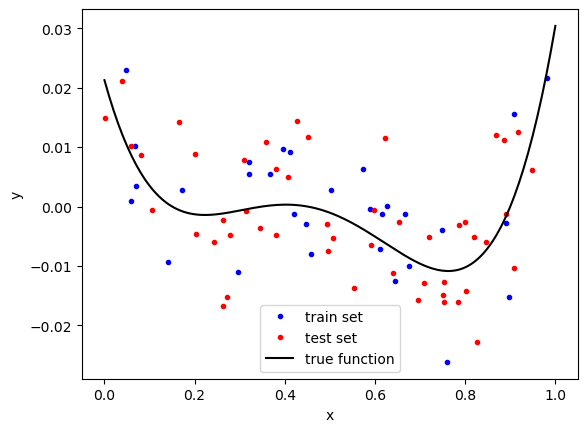

In [22]:
# Plot the model and the data
plt.plot(x_train, y_train, '.b', label='train set')
plt.plot(x_test, y_test, '.r', label='test set')

x_model = np.linspace(0, 1, 200)
y_model = np.polyval(true_model, x_model)
plt.plot(x_model, y_model, '-k', label='true function')

plt.xlabel('x')
plt.ylabel('y')
plt.legend();

#### Experiment: which model fits best?

In [23]:
def experiment(degree, ax):
    
    model = np.polyfit(x_train, y_train, degree)
    
    # Plot the model and the data
    ax.plot(x_train, y_train, '.b', label='train set')
    #ax.plot(x_test, y_test, '.r', label='test set')

    x_model = np.linspace(0, 1, 200)
    y_model = np.polyval(model, x_model)
    ax.plot(x_model, y_model, '-k', label=f'degree {degree} model')

    train_errors = y_train - np.polyval(model, x_train)
    test_errors = y_test - np.polyval(model, x_test)
    train_mae = np.average(np.absolute(train_errors))
    test_mae = np.average(np.absolute(test_errors))

    perf_text = 'train mae: {:.2e}\ntest mae: {:.2e}'.format(train_mae, test_mae)
    ax.text(0.5, 0.95, perf_text,
            verticalalignment='top', horizontalalignment='center',
            transform=ax.transAxes,
            color='black', fontsize=10)

    deg_text = f'degree {degree} model'
    ax.text(0.02, 0.02, deg_text,
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            color='black', fontsize=10)

    ax.set_ylim([-0.05, 0.05])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    #ax.set_xlabel('x')
    #ax.set_ylabel('y')
    # ax.legend();

/tmp/ipykernel_3163218/281435929.py:6: RankWarning: Polyfit may be poorly conditioned
  experiment(degree, axarr[degree // ncols][degree % ncols])
/tmp/ipykernel_3163218/281435929.py:6: RankWarning: Polyfit may be poorly conditioned
  experiment(degree, axarr[degree // ncols][degree % ncols])


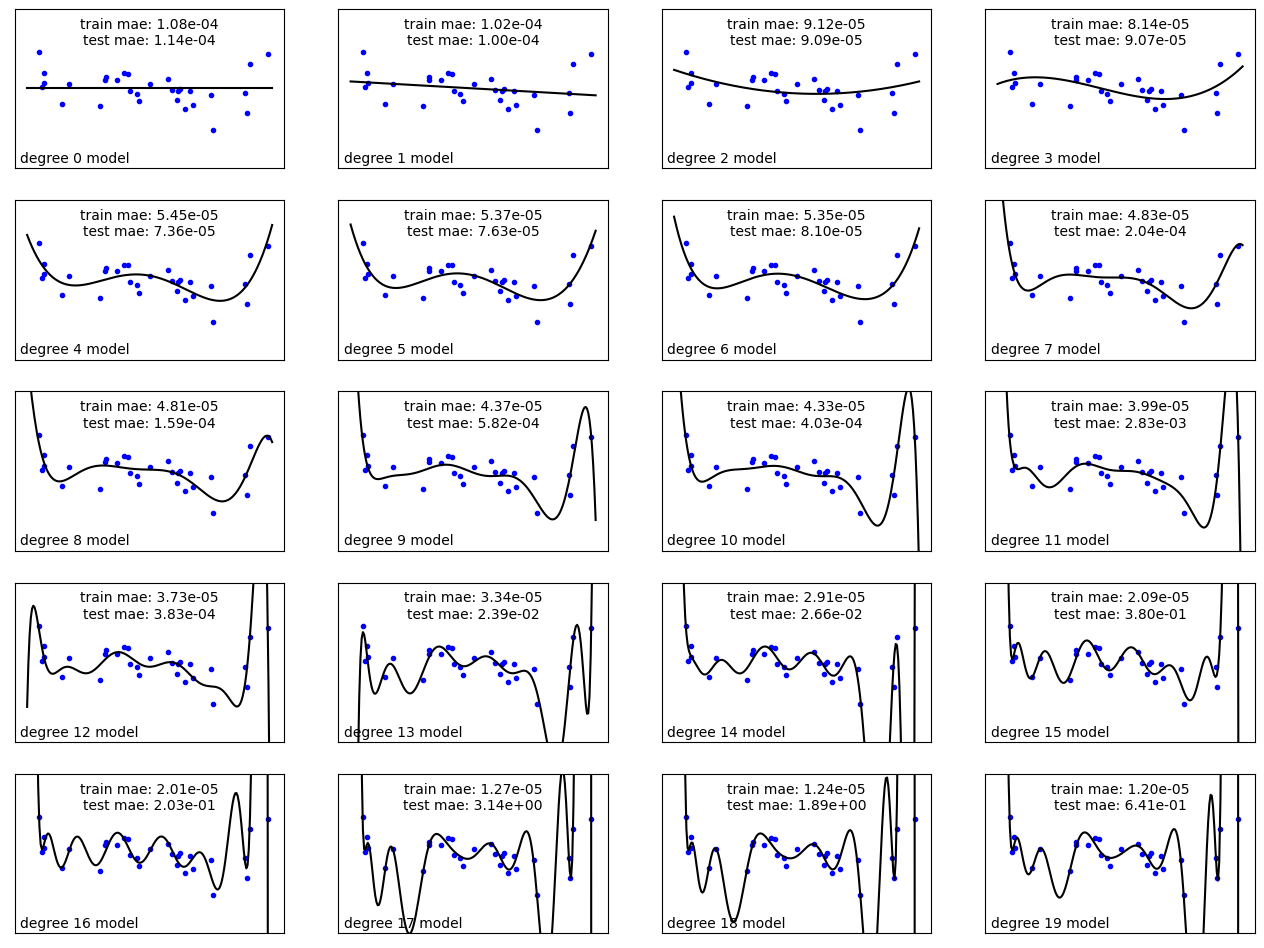

In [24]:
nrows = 5
ncols = 4
nplots = ncols * nrows
fig, axarr = plt.subplots(nrows, ncols, sharex=True, figsize=(16,12))
for degree in range(0, nplots):
    experiment(degree, axarr[degree // ncols][degree % ncols])

#### Experiment: Peformance vs Model Complexity
Redo the experiment above. But don't plot the individual models. Just plot the performance of the models.

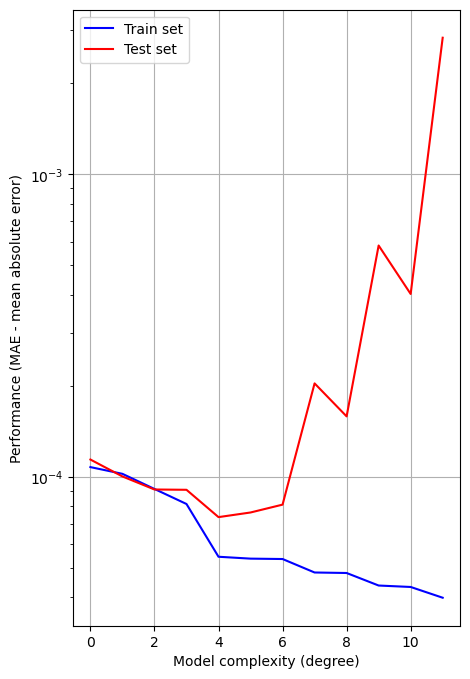

In [25]:
degrees = np.arange(0, 12)
train_mae = []
test_mae = []

for degree in degrees:
    model = np.polyfit(x_train, y_train, degree)
    
    train_errors = y_train - np.polyval(model, x_train)
    test_errors = y_test - np.polyval(model, x_test)
    train_mae.append(np.average(np.absolute(train_errors)))
    test_mae.append(np.average(np.absolute(test_errors)))

fig, ax = plt.subplots(1, 1, figsize=(5,8))
ax.plot(degrees, train_mae, '-b', label='Train set')
ax.plot(degrees, test_mae, '-r', label='Test set')

ax.set_yscale('log')
ax.grid('on')
ax.set_xlabel('Model complexity (degree)')
ax.set_ylabel('Performance (MAE - mean absolute error)')
ax.legend();

### Summary: Model Complexity

Bigger models have more parameters. They can fit more things than simple models. Training performance pretty much always improves with higher complexity, but that isn't real! When we check against the test set we see that there's a sweet spot for the right complexity, and anything more than that makes us do worse.

## Topic: Elements of ML models in computer vision

Here's an example neural network from our code last class:

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

Recall, some layers of models have parameters. Where are the parameters in the model above? How many parameters are there?

In [27]:
for name, param in model.named_parameters():
    print(name.ljust(16), param.shape)
print('Total num parameters:', sum([x.numel() for x in model.parameters()]))

conv1.weight     torch.Size([32, 3, 3, 3])
conv1.bias       torch.Size([32])
conv2.weight     torch.Size([64, 32, 3, 3])
conv2.bias       torch.Size([64])
fc1.weight       torch.Size([512, 4096])
fc1.bias         torch.Size([512])
fc2.weight       torch.Size([10, 512])
fc2.bias         torch.Size([10])
Total num parameters: 2122186


### Whiteboard time: NN layers: FC and Conv2d

Summary: 
- A **fully connected** layer performs the operation $y = W x + b$ where $x$ is the input to the layer, $y$ is the output, $W$ are the *weights*, and $b$ are the *biases*. The weights and biases are the parameters to this layer.
- A **convolutional** layer performs the operation $y = x \ast K + b$ where $x$ is the input to the layer, $y$ is the output, $K$ are the *weights/filters*, and $b$ are the *biases*. The weights and biases are the parameters to this layer.

Here's a list of all of the 
[layers in torch.nn](https://pytorch.org/docs/stable/nn.html).
These are the building blocks of neural networks.

### Useful layers:
- `torch.nn.Linear` [[docs]](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
- `torch.nn.Conv2d` [[docs]](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
- `torch.nn.MaxPool2d` [[docs]](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- `torch.nn.UpsampleBilinear2d` [[docs]](https://pytorch.org/docs/stable/generated/torch.nn.UpsamplingBilinear2d.html#torch.nn.UpsamplingBilinear2d)

Activation functions:
- `torch.nn.ReLU` [[docs]](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
- `torch.nn.Sigmoid` [[docs]](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)

## Topic: Model Architectures

There are so many options to make models! Mix and match layers.

In practice, ML engineers don't spend a lot of time searching for the best architectures. Instead, we have collected a short list of famous model architectures that have performed surprisingly well for many problems. Then we tweak them (different input sizes, more or fewer parameters) as needed.

(Small lie! With the latest and greatest approaches, most ML engineers don't need to train models from scratch. Later we'll talk about the encoder/decoder pattern and how to use pre-trained *foundation* models as the core of new methods.)

### Examples of architectures that have worked really well

- AlexNet [[link]](https://paperswithcode.com/method/alexnet)
- GoogleLeNet [[link]](https://paperswithcode.com/method/googlenet)
- ResNet [[link]](https://paperswithcode.com/method/resnet)
- U-Net [[link]](https://paperswithcode.com/method/u-net)


### But what do these architectures mean?

There are a couple papers that try to visualize what neural networks are learning.

- [[AlexNet viz]](https://paperswithcode.com/paper/visualizing-and-understanding-convolutional)
- [[GoogleLeNet viz]](https://distill.pub/2017/feature-visualization/)

Click through and look at them!

Summary:
- The earliest layers learn simple filters: color, edge, orientation
- The next layers are learning shape and texture
- These models are learning heirarchical knowledge: later layers are based on what was learned in earlier layers
- Later layers get increasingly abstract. You start to see "face" filters and "wheel" filters and the like.

## Spare Time: Final project topic clinic